In [1]:
# First, load the IPython extension for auto-reloading
%load_ext autoreload
%autoreload 2

import pickle
import torch
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

from src.eval.evaluate_model import (
    evaluate_model,
    evaluate_by_hydrophone,
    evaluate_by_anomaly_type,
    plot_confusion_matrix,
    plot_example_spectrograms,
    plot_threshold_f1f2_curve,
    plot_all_false_positives,
    plot_all_false_negatives
)
from src.utilities.training_utils import create_model
from src.onc_dataset import ONCSpectrogramDataset
from src.models import AMBAModel
from torch.utils.data import DataLoader

/home/merileo/ssamba/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/merileo/ssamba/myenv/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/merileo/ssamba/myenv/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


VisionMamba imported successfully
RMSNorm imported successfully


In [2]:
# Path to your model directory
model_dir = Path("/scratch/merileo/exp/amba-base-f16-t16-b16-lr1e-4-m300-custom-tr0.8-exp1")
checkpoint_path = str(model_dir / "models/ft-cls_best_checkpoint.pth")

# Load the saved args
with open(model_dir / "args.pkl", "rb") as f:
    args = pickle.load(f)

# Create and load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(args)
model = model.to(device)

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
if 'model_state_dict' in checkpoint:
    state_dict = checkpoint['model_state_dict']
else:
    state_dict = checkpoint

model.load_state_dict(state_dict)

Models directory: /scratch/merileo/exp/amba-base-f16-t16-b16-lr1e-4-m300-custom-tr0.8-exp1/models
Found pretrained checkpoint: pretrain-joint_best_checkpoint.pth
Vision Mamba Config: {'img_size': (512, 512), 'patch_size': 16, 'stride': 16, 'embed_dim': 768, 'depth': 24, 'channels': 1, 'num_classes': 2, 'drop_rate': 0.0, 'drop_path_rate': 0.1, 'norm_epsilon': 1e-05, 'rms_norm': False, 'residual_in_fp32': False, 'fused_add_norm': False, 'if_rope': False, 'if_rope_residual': False, 'bimamba_type': 'v2', 'if_cls_token': True, 'if_devide_out': True, 'use_double_cls_token': False, 'use_middle_cls_token': False, 'if_bidirectional': True, 'final_pool_type': 'none', 'if_abs_pos_embed': True, 'if_bimamba': False}
Loading pretrained model from: /scratch/merileo/exp/amba-base-f16-t16-b16-lr1e-4-m300-custom-tr0.8-exp1/models/pretrain-joint_best_checkpoint.pth
Loaded state dict keys: dict_keys(['epoch', 'global_step', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'best_metrics'

<All keys matched successfully>

In [3]:
# Load the test data
data_path = '/scratch/merileo/different_locations_incl_backgroundpipelinenormals_multilabel.h5'

# Create test dataset using the same args that were used during training
test_dataset = ONCSpectrogramDataset(
    data_path=data_path,  # or args.data_eval if you used a separate test set
    split='test',
    train_ratio=args.train_ratio,
    val_ratio=args.val_ratio,
    seed=args.split_seed if hasattr(args, 'split_seed') else 42,
    target_length=args.target_length,
    num_mel_bins=args.num_mel_bins,
    supervised=True,
    dataset_mean=args.dataset_mean,
    dataset_std=args.dataset_std,
    subsample_test=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=4
)


[DEBUG] Found 'sources' dataset in HDF5 file with shape (16500,)
[DEBUG] First few sources: [b'ICLISTENHF1951_20240902T173038.996Z_20240902T173538.996Z-spect_plotRes.mat'
 b'ICLISTENHF1951_20240902T173447.989Z_20240902T173947.989Z-spect_plotRes.mat'
 b'ICLISTENHF1951_20240902T173947.989Z_20240902T174447.989Z-spect_plotRes.mat'
 b'ICLISTENHF1951_20240902T174535.989Z_20240902T175035.989Z-spect_plotRes.mat'
 b'ICLISTENHF1951_20240902T175035.989Z_20240902T175535.989Z-spect_plotRes.mat']
[DEBUG] Sources are stored as bytes, will decode to utf-8
[DEBUG] Created sample_info with 1650 samples
[DEBUG] First few sources in sample_info: ['ICLISTENHF1253', 'ICLISTENHF1253', 'ICLISTENHF1266', 'ICLISTENHF1253', 'ICLISTENHF1253']
Dataset initialized with supervised=True


/home/merileo/ssamba/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


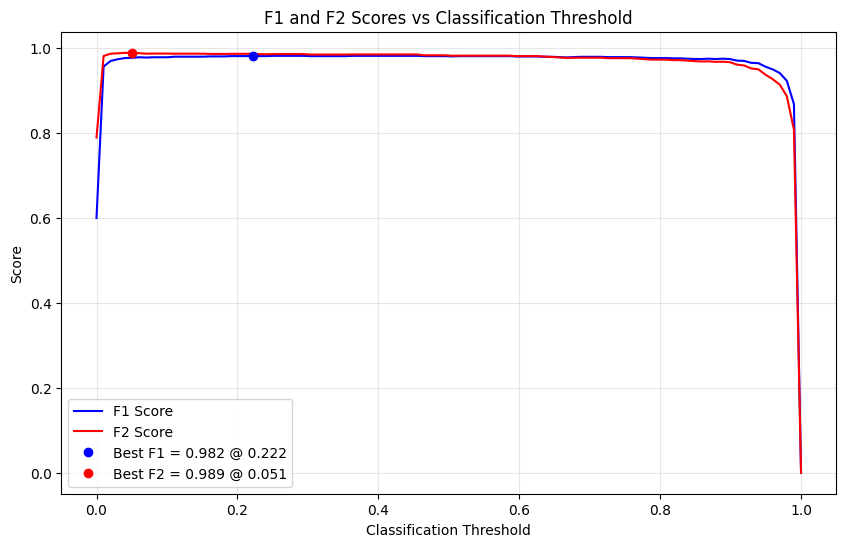

F1: Best score 0.982 at threshold 0.222
F2: Best score 0.989 at threshold 0.051


In [4]:
opt_thresh_f1, opt_thresh_f2, best_f1, best_f2 = plot_threshold_f1f2_curve(
    model=model,
    test_loader=test_loader,
    device=device,
    task=args.task
)

print(f"F1: Best score {best_f1:.3f} at threshold {opt_thresh_f1:.3f}")
print(f"F2: Best score {best_f2:.3f} at threshold {opt_thresh_f2:.3f}")

In [25]:
# Get overall metrics
metrics, y_true, y_pred, sources = evaluate_model(model, test_loader, threshold=0.051)
print("Overall metrics:", metrics)

Overall metrics: {'accuracy': 0.9812121212121212, 'precision': 0.9604904632152589, 'recall': 0.9971711456859972, 'f1': 0.9784871616932687, 'f2': 0.9896125772038181, 'normal_acc': 0.9692470837751855, 'anomaly_acc': 0.9971711456859972}


In [6]:
# Get hydrophone-specific metrics
hydrophone_df = evaluate_by_hydrophone(y_true, y_pred, sources)
display(hydrophone_df)



/home/merileo/ssamba/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/merileo/ssamba/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/merileo/ssamba/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/merileo/ssamba/myenv

hydrophone  samples  anomaly_rate  precision    recall  \
0               ICLISTENHF1252        1      1.000000   1.000000  1.000000   
1               ICLISTENHF1253      304      0.000000   0.000000  0.000000   
2               ICLISTENHF1266      228      0.135965   1.000000  0.967742   
3               ICLISTENHF1354      459      0.912854   0.965278  0.995227   
4               ICLISTENHF1951      103      0.330097   0.911765  0.911765   
5               ICLISTENHF6020       83      0.000000   0.000000  0.000000   
6               ICLISTENHF6093       80      0.000000   0.000000  0.000000   
7               ICLISTENHF6094       60      0.000000   0.000000  0.000000   
8               ICLISTENHF6095       97      1.000000   1.000000  1.000000   
9               ICLISTENHF6324      178      0.382022   1.000000  0.985294   
10     JASCOAMARHYDROPHONE2402       21      1.000000   1.000000  1.000000   
11  JASCOAMARHYDROPHONED001022       18      1.000000   1.000000  1.000000   
12  JASCOAMARHYDROPHONEE000186       18      1.000000   1.000000  1.000000   

          f1        f2  
0   1.000000  1.000000  
1   0.000000  0.000000  
2   0.983607  0.974026  
3   0.980024  0.989089  
4   0.911765  0.911765  
5   0.000000  0.000000  
6   0.000000  0.000000  
7   0.000000  0.000000  
8   1.000000  1.000000  
9   0.992593  0.988201  
10  1.000000  1.000000  
11  1.000000  1.000000  
12  1.000000  1.000000


Debug: plot_confusion_matrix
Manual confusion matrix calculation:
TN: 47, FP: 1
FN: 0, TP: 0
Total: 48
Dataset size: 48

Sklearn confusion matrix:
[[47  1]
 [ 0  0]]


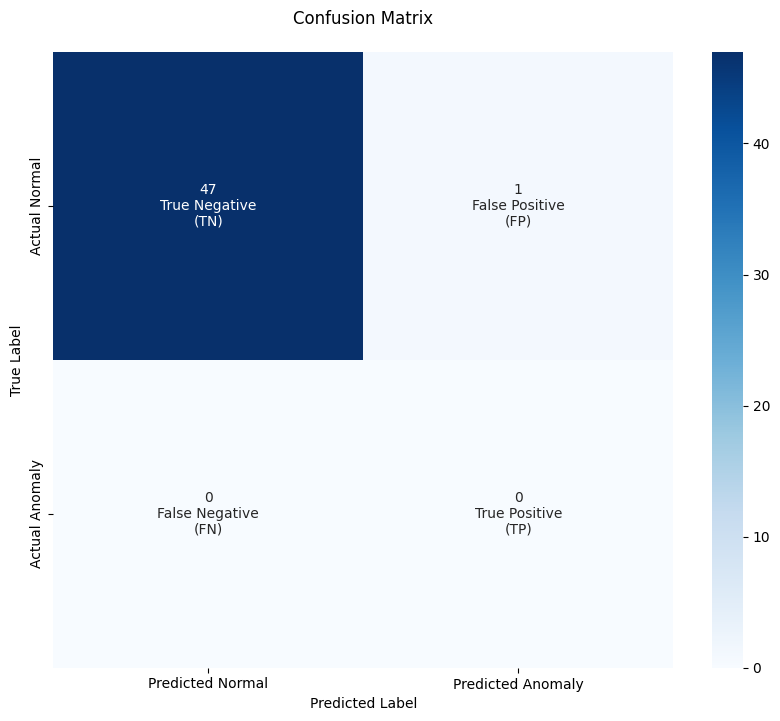

In [24]:
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred)




Category sizes:
True Positives: 700
True Negatives: 924
False Positives: 19
False Negatives: 7


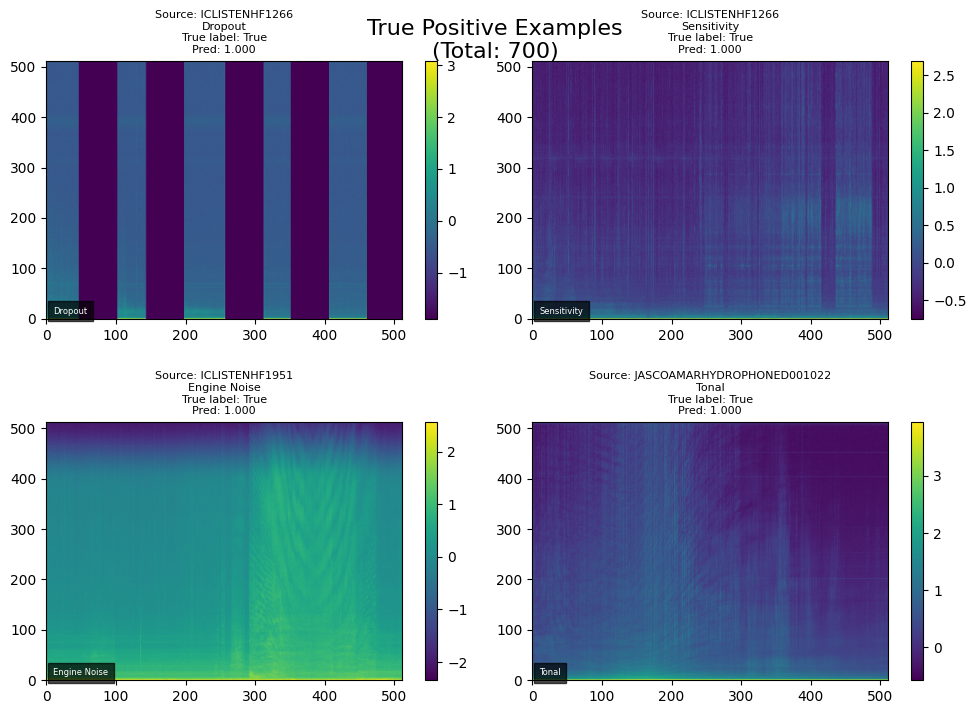

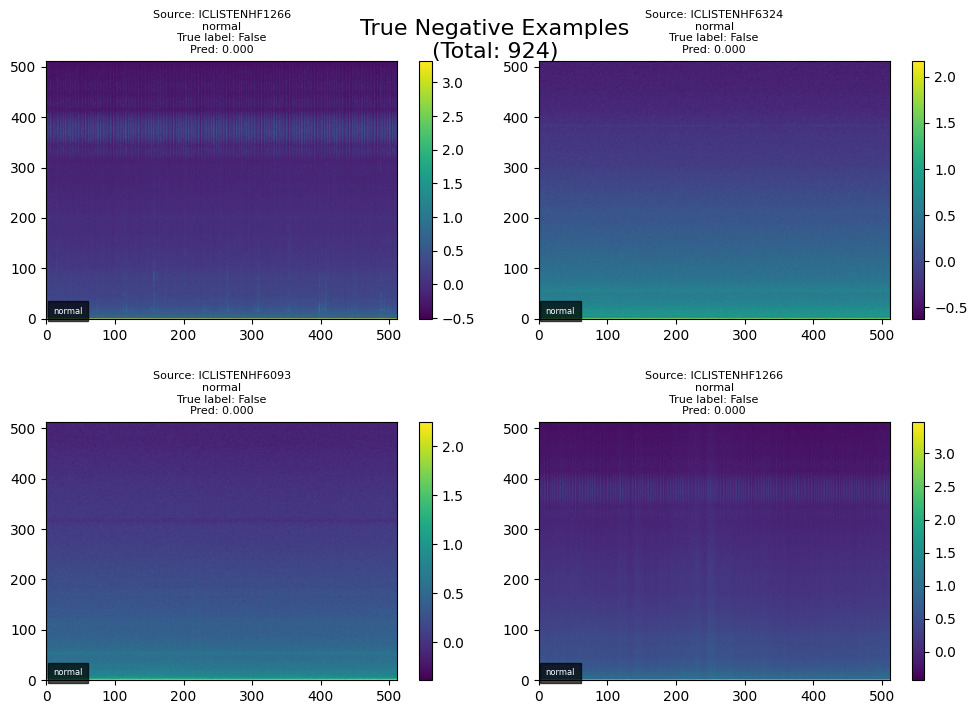

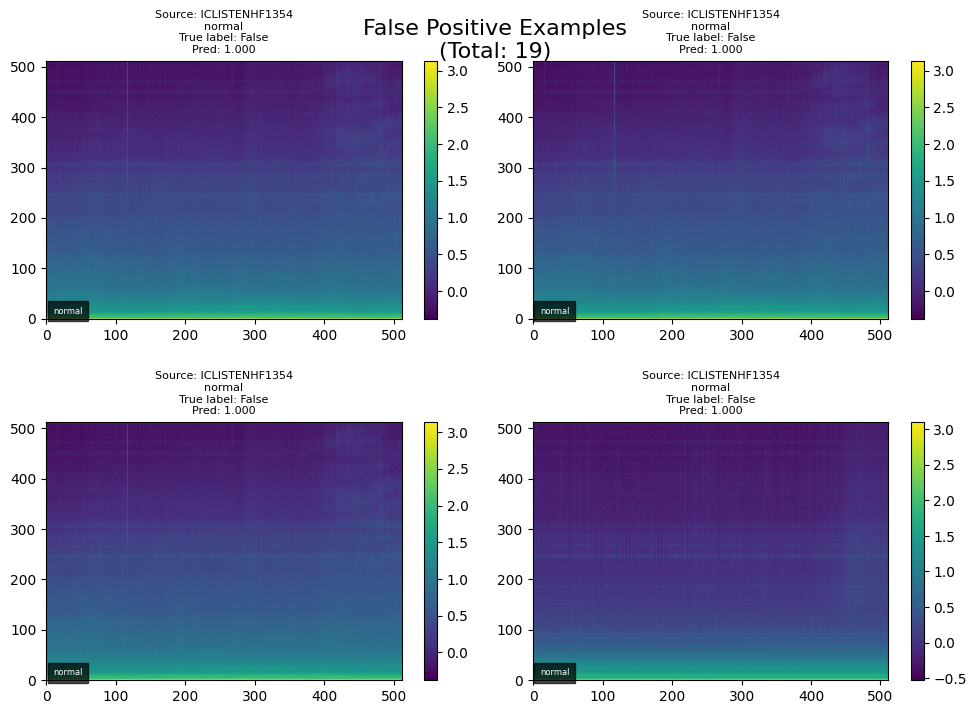

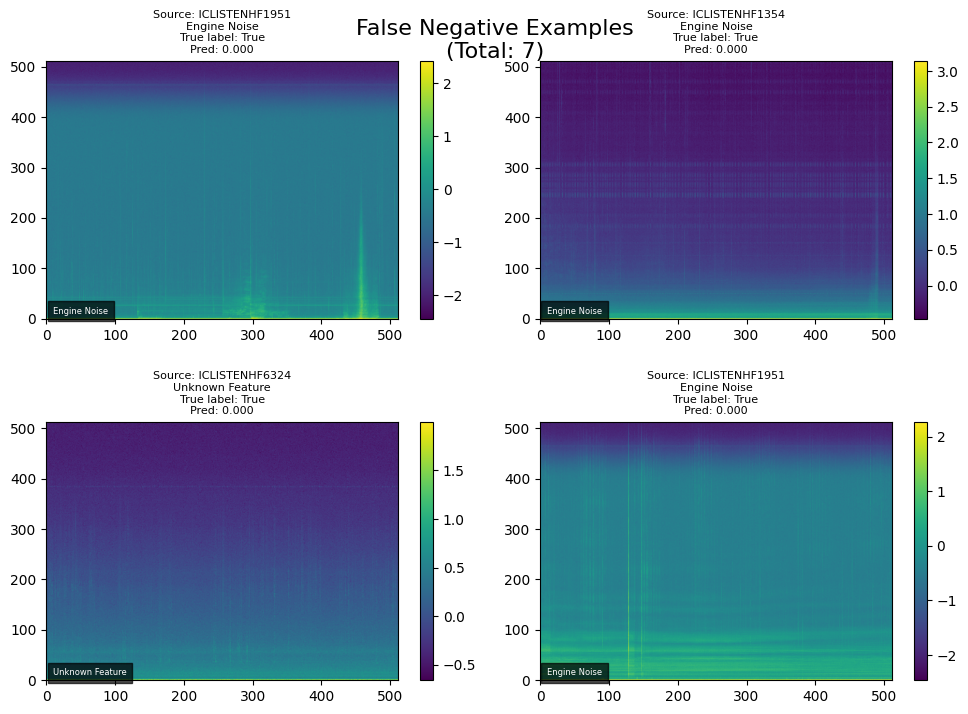

In [14]:
# Show example spectrograms
plot_example_spectrograms(test_dataset, y_pred, num_examples=4, samples_per_row=2)

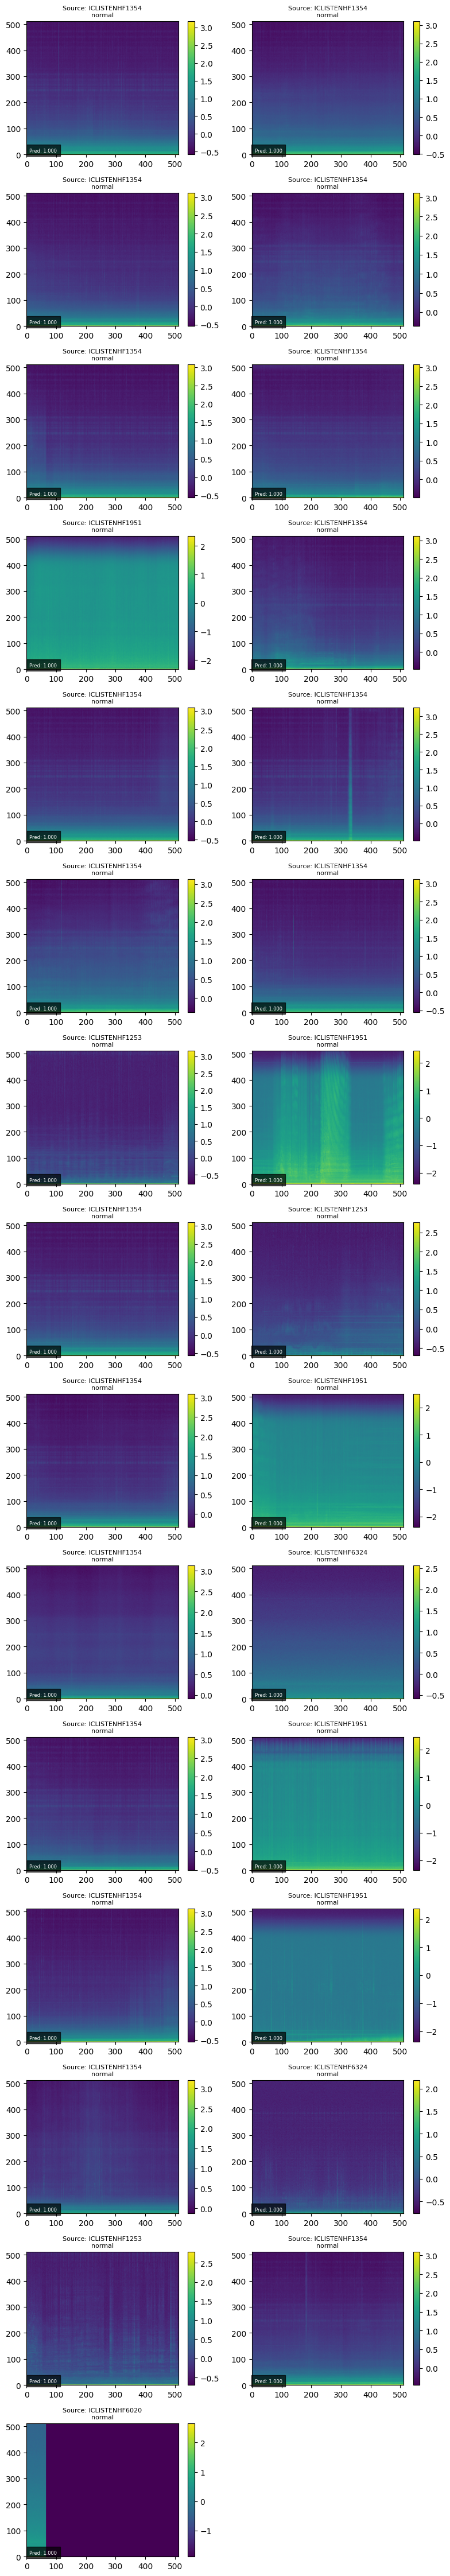

In [18]:
# To see all false positives
plot_all_false_positives(test_dataset, y_pred, samples_per_row=2)

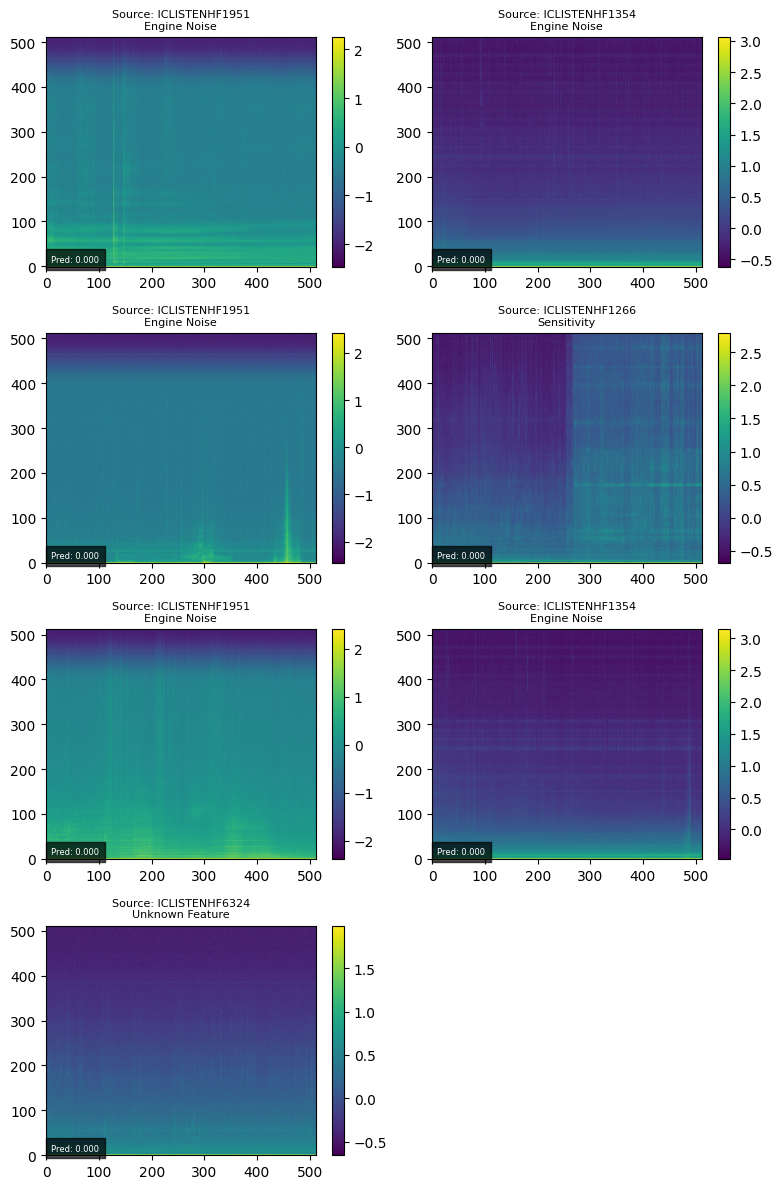

In [9]:
# To see all false negatives
plot_all_false_negatives(test_dataset, y_pred, samples_per_row=2)